# Capstone Project for Coursera
This notebook will be mainly used for capstone project of Coursera online certificate for **IBM Data Science Professional Ceritificate**.

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
print("Hello Capstone Project Course!")

Hello Capstone Project Course!


### Import Libraries

First import the libraries which will be used in this capstone project.

In [326]:
import json

# !conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim

import requests
from pandas.io.json import json_normalize

import matplotlib.cm as cm

from sklearn.cluster import KMeans

# !conda install -c conda-forge folium=0.5.0 --yes
import folium
print('Libraries imported.')

Libraries imported.


### Import Data

Next, using **BeautifulSoup** to transform the data in the table on the Wikipedia page into pandas dataframe. At the same time, cleanning dataframe as the requirement stated.

In [5]:
from bs4 import BeautifulSoup

with open('List of postal codes of Canada_ M - Wikipedia.html') as html_file:
    soup = BeautifulSoup(html_file, 'lxml')


In [6]:
table = soup.find('table', class_='wikitable sortable')
table_rows = table.find_all("tr")
table_columns = table.find_all("th")
l = []
for tr in table_rows:
    td = tr.find_all("td")
    row = [tr.text for tr in td]
    if row and row[1] != 'Not assigned':
        if row[2] == 'Not assigned\n':
            row[2] = row[1]
        l.append(row)
cols = [c.text.replace('\n', '') for c in table_columns]
df = pd.DataFrame(l, columns=cols).replace('\n', '', regex=True)
df = df.groupby(['Borough', 'Postcode'], sort=False).agg(lambda x: ', '.join(set(x.dropna()))).reset_index()
df = df[cols].replace('\n', '', regex=True)
df.head()

Postcode           Borough                     Neighbourhood
0      M3A        North York                         Parkwoods
1      M4A        North York                  Victoria Village
2      M5A  Downtown Toronto         Harbourfront, Regent Park
3      M6A        North York  Lawrence Heights, Lawrence Manor
4      M7A      Queen's Park                      Queen's Park

In [7]:
df.shape

(103, 3)

As the result of **shape** method, the size of this transformed table is **(103, 3)**.

Next step is add the **Latitude** and **Longitude** to the dataframe.

In [8]:
ll = pd.read_csv('Geospatial_Coordinates.csv')
ll.columns = ['Postcode', 'Latitude', 'Longitude']
cols = ['Postcode']
df_withll = df.join(ll.set_index(cols), on=cols)

### Use geopy library to get the latitude and longitude values of Toronto

In [9]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="ca_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


### Create a map of Ontario with neighborhoods superimposed on top

Create map of Toronto using latitude and longitude values, and then add markers to map

In [10]:

map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_withll['Latitude'], df_withll['Longitude'], df_withll['Borough'], df_withll['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

Then filtering the **Borough** by contains **Toronto**

In [11]:
df_tor = df_withll[df_withll['Borough'].str.contains("Toronto")]
df_tor.head()

Postcode           Borough              Neighbourhood   Latitude  Longitude
2       M5A  Downtown Toronto  Harbourfront, Regent Park  43.654260 -79.360636
9       M5B  Downtown Toronto   Garden District, Ryerson  43.657162 -79.378937
15      M5C  Downtown Toronto             St. James Town  43.651494 -79.375418
19      M4E      East Toronto                The Beaches  43.676357 -79.293031
20      M5E  Downtown Toronto                Berczy Park  43.644771 -79.373306

Creating map of Toronto using only Borough that contains Toronto.

In [12]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df_tor['Latitude'], df_tor['Longitude'], df_tor['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

### Define Foursquare Credentials and Version

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

In [13]:
CLIENT_ID = 'M5NXRZI5KMSVEMTB1FHXAKUUXF5ODQFPRDMJQEZ053TRIV4W' # your Foursquare ID
CLIENT_SECRET = 'HBRGKYXZTPLCSDZPS4HQEEGZFOTJ2LKL4N5XMURF0OW3URRB' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: M5NXRZI5KMSVEMTB1FHXAKUUXF5ODQFPRDMJQEZ053TRIV4W
CLIENT_SECRET:HBRGKYXZTPLCSDZPS4HQEEGZFOTJ2LKL4N5XMURF0OW3URRB


In [14]:
LIMIT = 100
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=M5NXRZI5KMSVEMTB1FHXAKUUXF5ODQFPRDMJQEZ053TRIV4W&client_secret=HBRGKYXZTPLCSDZPS4HQEEGZFOTJ2LKL4N5XMURF0OW3URRB&v=20180605&ll=43.653963,-79.387207&radius=500&limit=100'

In [15]:
results = requests.get(url).json()

In [16]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [17]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(5)

name        categories        lat        lng
0    Downtown Toronto      Neighborhood  43.653232 -79.385296
1             Japango  Sushi Restaurant  43.655268 -79.385165
2         Cafe Plenty              Café  43.654571 -79.389450
3           Poke Guys        Poke Place  43.654895 -79.385052
4  Sansotei Ramen 三草亭  Ramen Restaurant  43.655157 -79.386501

In [18]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

71 venues were returned by Foursquare.


Then explore neighborhoods in Toronto

In [19]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [20]:
toronto_venues = getNearbyVenues(names=df_tor['Neighbourhood'],
                                   latitudes=df_tor['Latitude'],
                                   longitudes=df_tor['Longitude']
                                  )



Harbourfront, Regent Park
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Toronto Islands, Harbourfront East, Union Station
Little Portugal, Trinity
Riverdale, The Danforth West
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
The Beaches West, India Bazaar
Victoria Hotel, Commerce Court
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North, Forest Hill West
The Junction South, High Park
North Toronto West
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
Harbord, University of Toronto
Runnymede, Swansea
Moore Park, Summerhill East
Grange Park, Kensington Market, Chinatown
Rathnelly, Forest Hill SE, Summerhill West, South Hill, Deer Park
Harbourfront West, Railway Lands, CN Tower, King and Spadina, Bathurst Quay, South Niagara, Island airport
Rosedale
Stn A PO Boxes 25 The Esplanade
St. James Town, Cabbagetown
Fir

#### See the size of toronto_venues dataframe

In [21]:
print(toronto_venues.shape)
toronto_venues.head()

(1690, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Harbourfront, Regent Park               43.65426              -79.360636   
1  Harbourfront, Regent Park               43.65426              -79.360636   
2  Harbourfront, Regent Park               43.65426              -79.360636   
3  Harbourfront, Regent Park               43.65426              -79.360636   
4  Harbourfront, Regent Park               43.65426              -79.360636   

                                             Venue  Venue Latitude  \
0                                 Roselle Desserts       43.653447   
1                                    Tandem Coffee       43.653559   
2  Toronto Cooper Koo Family Cherry St YMCA Centre       43.653191   
3                              Body Blitz Spa East       43.654735   
4                               Morning Glory Cafe       43.653947   

   Venue Longitude        Venue Category  
0       -79.362017                Bakery  
1       -79.361809           Coffee Shop  
2       -79.357947  Gym / Fitness Center  
3       -79.359874                   Spa  
4       -79.361149        Breakfast Spot

In [22]:
toronto_venues.groupby('Neighborhood').count().head()

Neighborhood Latitude  \
Neighborhood                                                               
Berczy Park                                                           56   
Brockton, Parkdale Village, Exhibition Place                          23   
Business Reply Mail Processing Centre 969 Eastern                     16   
Central Bay Street                                                    82   
Christie                                                              16   

                                                   Neighborhood Longitude  \
Neighborhood                                                                
Berczy Park                                                            56   
Brockton, Parkdale Village, Exhibition Place                           23   
Business Reply Mail Processing Centre 969 Eastern                      16   
Central Bay Street                                                     82   
Christie                                                               16   

                                                   Venue  Venue Latitude  \
Neighborhood                                                               
Berczy Park                                           56              56   
Brockton, Parkdale Village, Exhibition Place          23              23   
Business Reply Mail Processing Centre 969 Eastern     16              16   
Central Bay Street                                    82              82   
Christie                                              16              16   

                                                   Venue Longitude  \
Neighborhood                                                         
Berczy Park                                                     56   
Brockton, Parkdale Village, Exhibition Place                    23   
Business Reply Mail Processing Centre 969 Eastern               16   
Central Bay Street                                              82   
Christie                                                        16   

                                                   Venue Category  
Neighborhood                                                       
Berczy Park                                                    56  
Brockton, Parkdale Village, Exhibition Place                   23  
Business Reply Mail Processing Centre 969 Eastern              16  
Central Bay Street                                             82  
Christie                                                       16

In [23]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 232 uniques categories.


There are 235 uniques categories can be curated from all the returned venues. Then we analyze each neigborhood.

In [24]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

Yoga Studio  Afghan Restaurant  Airport  Airport Food Court  Airport Gate  \
0            0                  0        0                   0             0   
1            0                  0        0                   0             0   
2            0                  0        0                   0             0   
3            0                  0        0                   0             0   
4            0                  0        0                   0             0   

   Airport Lounge  Airport Service  Airport Terminal  American Restaurant  \
0               0                0                 0                    0   
1               0                0                 0                    0   
2               0                0                 0                    0   
3               0                0                 0                    0   
4               0                0                 0                    0   

   Antique Shop  Aquarium  Art Gallery  Arts & Crafts Store  Asian Restaurant  \
0             0         0            0                    0                 0   
1             0         0            0                    0                 0   
2             0         0            0                    0                 0   
3             0         0            0                    0                 0   
4             0         0            0                    0                 0   

   Athletics & Sports  Auto Workshop  BBQ Joint  Baby Store  Bagel Shop  \
0                   0              0          0           0           0   
1                   0              0          0           0           0   
2                   0              0          0           0           0   
3                   0              0          0           0           0   
4                   0              0          0           0           0   

   Bakery  Bank  Bar  Baseball Stadium  Basketball Stadium  Beach  \
0       1     0    0                 0                   0      0   
1       0     0    0                 0                   0      0   
2       0     0    0                 0                   0      0   
3       0     0    0                 0                   0      0   
4       0     0    0                 0                   0      0   

   Bed & Breakfast  Beer Bar  Beer Store  Bistro  Boat or Ferry  Bookstore  \
0                0         0           0       0              0          0   
1                0         0           0       0              0          0   
2                0         0           0       0              0          0   
3                0         0           0       0              0          0   
4                0         0           0       0              0          0   

   Boutique  Brazilian Restaurant  Breakfast Spot  Brewery  Bubble Tea Shop  \
0         0                     0               0        0                0   
1         0                     0               0        0                0   
2         0                     0               0        0                0   
3         0                     0               0        0                0   
4         0                     0               1        0                0   

   Building  Burger Joint  Burrito Place  Bus Line  Butcher  Café  \
0         0             0              0         0        0     0   
1         0             0              0         0        0     0   
2         0             0              0         0        0     0   
3         0             0              0         0        0     0   
4         0             0              0         0        0     0   

   Cajun / Creole Restaurant  Camera Store  Caribbean Restaurant  Cheese Shop  \
0                          0             0                     0            0   
1                          0             0                     0            0   
2                          0             0                     0            0   
3                      

In [25]:
def column_index(df, query_cols):
    cols = df.columns.values
    sidx = np.argsort(cols)
    return sidx[np.searchsorted(cols,query_cols,sorter=sidx)]

In [26]:
column_index(toronto_onehot,['Neighborhood'])

array([160])

In [86]:
toronto_onehot = toronto_onehot.set_index(toronto_onehot.columns[159]).reset_index()

In [87]:
toronto_onehot.head()

Neighborhood  Yoga Studio  Afghan Restaurant  Airport  \
0  Harbourfront, Regent Park            0                  0        0   
1  Harbourfront, Regent Park            0                  0        0   
2  Harbourfront, Regent Park            0                  0        0   
3  Harbourfront, Regent Park            0                  0        0   
4  Harbourfront, Regent Park            0                  0        0   

   Airport Food Court  Airport Gate  Airport Lounge  Airport Service  \
0                   0             0               0                0   
1                   0             0               0                0   
2                   0             0               0                0   
3                   0             0               0                0   
4                   0             0               0                0   

   Airport Terminal  American Restaurant  Antique Shop  Aquarium  Art Gallery  \
0                 0                    0             0         0            0   
1                 0                    0             0         0            0   
2                 0                    0             0         0            0   
3                 0                    0             0         0            0   
4                 0                    0             0         0            0   

   Arts & Crafts Store  Asian Restaurant  Athletics & Sports  Auto Workshop  \
0                    0                 0                   0              0   
1                    0                 0                   0              0   
2                    0                 0                   0              0   
3                    0                 0                   0              0   
4                    0                 0                   0              0   

   BBQ Joint  Baby Store  Bagel Shop  Bakery  Bank  Bar  Baseball Stadium  \
0          0           0           0       1     0    0                 0   
1          0           0           0       0     0    0                 0   
2          0           0           0       0     0    0                 0   
3          0           0           0       0     0    0                 0   
4          0           0           0       0     0    0                 0   

   Basketball Stadium  Beach  Bed & Breakfast  Beer Bar  Beer Store  Bistro  \
0                   0      0                0         0           0       0   
1                   0      0                0         0           0       0   
2                   0      0                0         0           0       0   
3                   0      0                0         0           0       0   
4                   0      0                0         0           0       0   

   Boat or Ferry  Bookstore  Boutique  Brazilian Restaurant  Breakfast Spot  \
0              0          0         0                     0               0   
1              0          0         0                     0               0   
2              0          0         0                     0               0   
3              0          0         0                     0               0   
4              0          0         0                     0               1   

   Brewery  Bubble Tea Shop  Building  Burger Joint  Burrito Place  Bus Line  \
0        0                0         0             0              0         0   
1        0                0         0             0              0         0   
2        0                0         0             0              0         0   
3        0                0         0             0              0         0   
4        0                0         0             0              0         0   

   Butcher  Café  Cajun / Creole Restaurant  Camera Store  \
0        0     0                          0             0   
1        0     0                          0             0   
2        0     0                          0             0   
3        0     0                          0 

In [29]:
toronto_onehot.shape

(1690, 231)

#### Next, group rows by neighborhood and by taking the mean of the frequency of occurrence of each category 

In [90]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

Neighborhood  Yoga Studio  \
0                                        Berczy Park     0.000000   
1       Brockton, Parkdale Village, Exhibition Place     0.043478   
2  Business Reply Mail Processing Centre 969 Eastern     0.000000   
3                                 Central Bay Street     0.012195   
4                                           Christie     0.000000   

   Afghan Restaurant  Airport  Airport Food Court  Airport Gate  \
0                0.0      0.0                 0.0           0.0   
1                0.0      0.0                 0.0           0.0   
2                0.0      0.0                 0.0           0.0   
3                0.0      0.0                 0.0           0.0   
4                0.0      0.0                 0.0           0.0   

   Airport Lounge  Airport Service  Airport Terminal  American Restaurant  \
0             0.0              0.0               0.0             0.000000   
1             0.0              0.0               0.0             0.000000   
2             0.0              0.0               0.0             0.000000   
3             0.0              0.0               0.0             0.012195   
4             0.0              0.0               0.0             0.000000   

   Antique Shop  Aquarium  Art Gallery  Arts & Crafts Store  Asian Restaurant  \
0           0.0       0.0     0.017857                  0.0               0.0   
1           0.0       0.0     0.000000                  0.0               0.0   
2           0.0       0.0     0.000000                  0.0               0.0   
3           0.0       0.0     0.000000                  0.0               0.0   
4           0.0       0.0     0.000000                  0.0               0.0   

   Athletics & Sports  Auto Workshop  BBQ Joint  Baby Store  Bagel Shop  \
0              0.0000         0.0000   0.017857      0.0000    0.017857   
1              0.0000         0.0000   0.000000      0.0000    0.000000   
2              0.0000         0.0625   0.000000      0.0000    0.000000   
3              0.0000         0.0000   0.000000      0.0000    0.000000   
4              0.0625         0.0000   0.000000      0.0625    0.000000   

     Bakery  Bank       Bar  Baseball Stadium  Basketball Stadium     Beach  \
0  0.035714   0.0  0.000000               0.0            0.017857  0.017857   
1  0.000000   0.0  0.043478               0.0            0.000000  0.000000   
2  0.000000   0.0  0.000000               0.0            0.000000  0.000000   
3  0.024390   0.0  0.024390               0.0            0.000000  0.000000   
4  0.000000   0.0  0.000000               0.0            0.000000  0.000000   

   Bed & Breakfast  Beer Bar  Beer Store    Bistro  Boat or Ferry  Bookstore  \
0              0.0  0.035714         0.0  0.017857            0.0        0.0   
1              0.0  0.000000         0.0  0.000000            0.0        0.0   
2              0.0  0.000000         0.0  0.000000            0.0        0.0   
3              0.0  0.000000         0.0  0.000000            0.0        0.0   
4              0.0  0.000000         0.0  0.000000            0.0        0.0   

   Boutique  Brazilian Restaurant  Breakfast Spot  Brewery  Bubble Tea Shop  \
0       0.0                   0.0        0.017857   0.0000          0.00000   
1       0.0                   0.0        0.086957   0.0000          0.00000   
2       0.0                   0.0        0.000000   0.0625          0.00000   
3       0.0                   0.0        0.000000   0.0000          0.02439   
4       0.0                   0.0        0.000000   0.0000          0.00000   

   Building  Burger Joint  Burrito Place  Bus Line   Butcher      Café  \
0       0.0      0.000000       0.000000       0.0  0.017857  0.035714   
1       0.0      0.000000       0.043478       0.0  0.000000  0.086957   
2       0.0      0.000000       0.062500       0.0  0.000000  0.000000   
3       0.0      0.036585       0.000000       0.0  0.000000  0.060976   
4       0.0      0.0

In [91]:
toronto_grouped.shape

(38, 231)

#### Print each neighborhood along with the top 5 most common venues

In [92]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park----
                venue  freq
0         Coffee Shop  0.09
1        Cocktail Bar  0.05
2              Bakery  0.04
3  Seafood Restaurant  0.04
4         Cheese Shop  0.04


----Brockton, Parkdale Village, Exhibition Place----
            venue  freq
0  Breakfast Spot  0.09
1            Café  0.09
2     Coffee Shop  0.09
3     Yoga Studio  0.04
4             Bar  0.04


----Business Reply Mail Processing Centre 969 Eastern----
           venue  freq
0            Spa  0.06
1     Restaurant  0.06
2  Burrito Place  0.06
3     Smoke Shop  0.06
4     Skate Park  0.06


----Central Bay Street----
                venue  freq
0         Coffee Shop  0.15
1                Café  0.06
2      Ice Cream Shop  0.05
3  Italian Restaurant  0.05
4        Burger Joint  0.04


----Christie----
                venue  freq
0                Café  0.19
1       Grocery Store  0.19
2                Park  0.12
3          Restaurant  0.06
4  Athletics & Sports  0.06


----Church and Wellesley----


In [93]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [871]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue  \
0                                        Berczy Park           Coffee Shop   
1       Brockton, Parkdale Village, Exhibition Place        Breakfast Spot   
2  Business Reply Mail Processing Centre 969 Eastern        Farmers Market   
3                                 Central Bay Street           Coffee Shop   
4                                           Christie         Grocery Store   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0          Cocktail Bar        Farmers Market              Beer Bar   
1                  Café           Coffee Shop           Yoga Studio   
2         Auto Workshop                  Park           Pizza Place   
3                  Café    Italian Restaurant        Ice Cream Shop   
4                  Café                  Park    Italian Restaurant   

  5th Most Common Venue 6th Most Common Venue      7th Most Common Venue  \
0                Bakery            Steakhouse                Cheese Shop   
1                   Bar         Burrito Place       Caribbean Restaurant   
2            Restaurant         Burrito Place                    Brewery   
3        Sandwich Place          Burger Joint  Middle Eastern Restaurant   
4            Baby Store                 Diner         Athletics & Sports   

  8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
0    Seafood Restaurant                  Café                   Park  
1            Restaurant          Climbing Gym                    Gym  
2            Skate Park            Smoke Shop     Light Rail Station  
3                   Spa                   Bar                 Bakery  
4            Restaurant             Nightclub            Coffee Shop

#### Using both Tsne and PCA to reduce data dimension for better kmeans clustering

In [1157]:
from sklearn.manifold import TSNE
from sklearn.decomposition import SparsePCA
from sklearn.decomposition import PCA


toronto_grouped_clustering = np.array(toronto_grouped.drop('Neighborhood', 1))
X_embedded = TSNE(n_components=25, method="exact").fit_transform(toronto_grouped_clustering)
# X_embedded = PCA(n_components=3).fit_transform(toronto_grouped_clustering)
X_embedded.shape

(38, 25)

#### Selecting the number of clusters with silhouette analysis on KMeans clustering
- As the silhouette score shows, the prefered k is 5.

For n_clusters = 4 The average silhouette_score is : 0.044006463
For n_clusters = 5 The average silhouette_score is : 0.14381737
For n_clusters = 6 The average silhouette_score is : 0.13011448
For n_clusters = 7 The average silhouette_score is : 0.036543734
For n_clusters = 8 The average silhouette_score is : 0.054566614
For n_clusters = 9 The average silhouette_score is : 0.1095601
For n_clusters = 10 The average silhouette_score is : 0.027812416
For n_clusters = 11 The average silhouette_score is : 0.05341663
For n_clusters = 12 The average silhouette_score is : 0.051195923
For n_clusters = 13 The average silhouette_score is : 0.052923743
For n_clusters = 14 The average silhouette_score is : 0.03224609
For n_clusters = 15 The average silhouette_score is : 0.024509335
For n_clusters = 16 The average silhouette_score is : 0.054859925
For n_clusters = 17 The average silhouette_score is : 0.027826212
For n_clusters = 18 The average silhouette_score is : 0.04006004
For n_clusters = 19 The

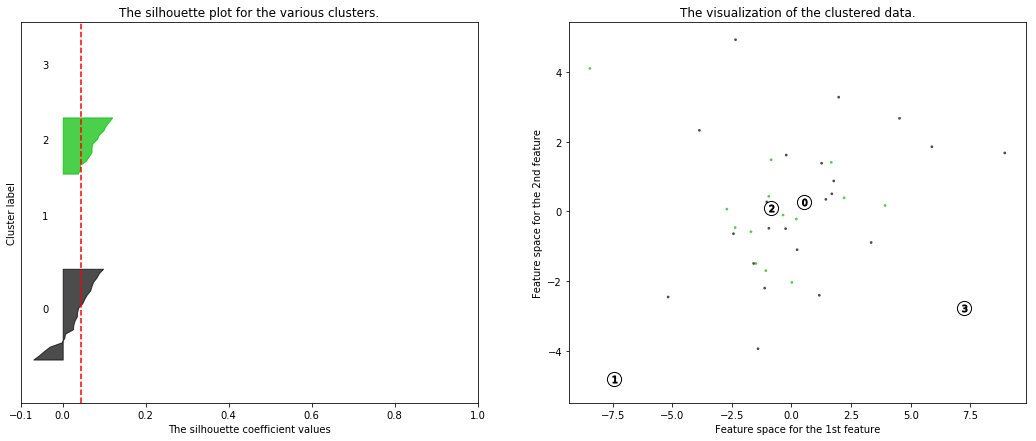

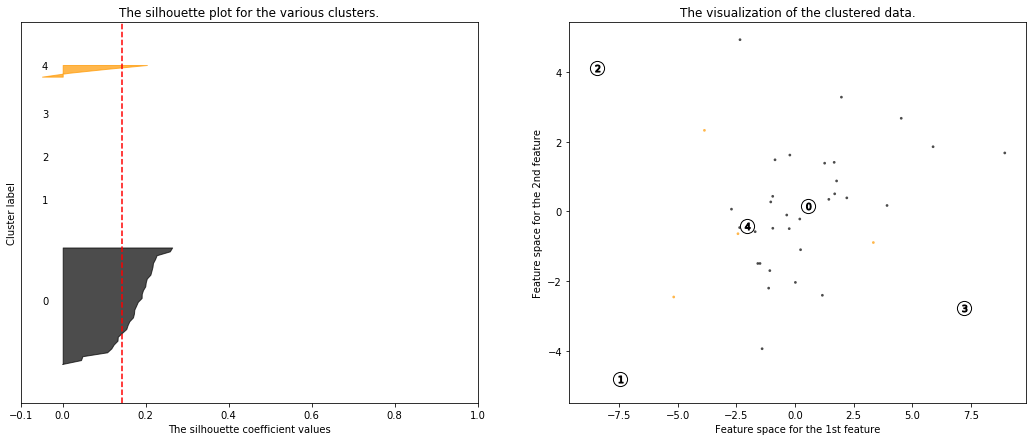

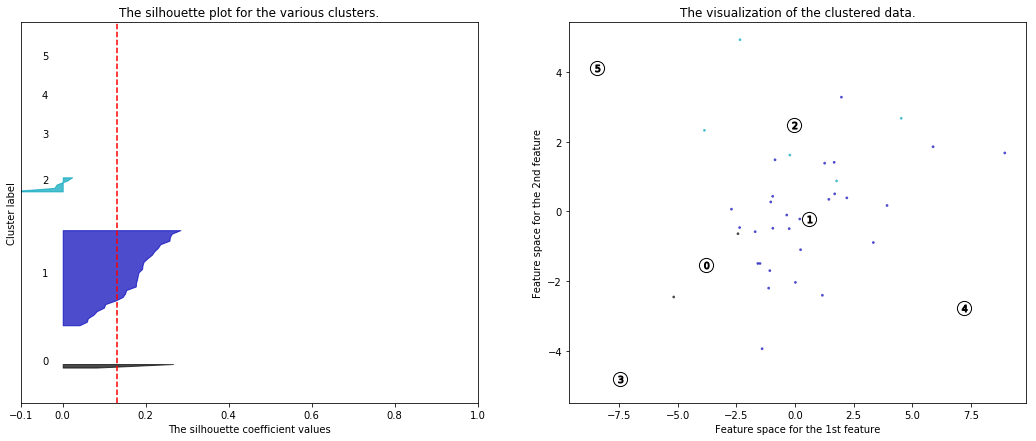

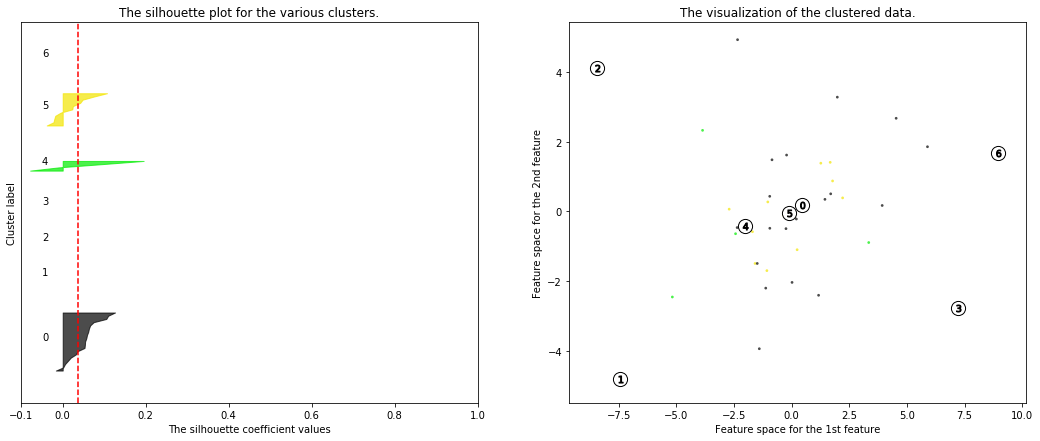

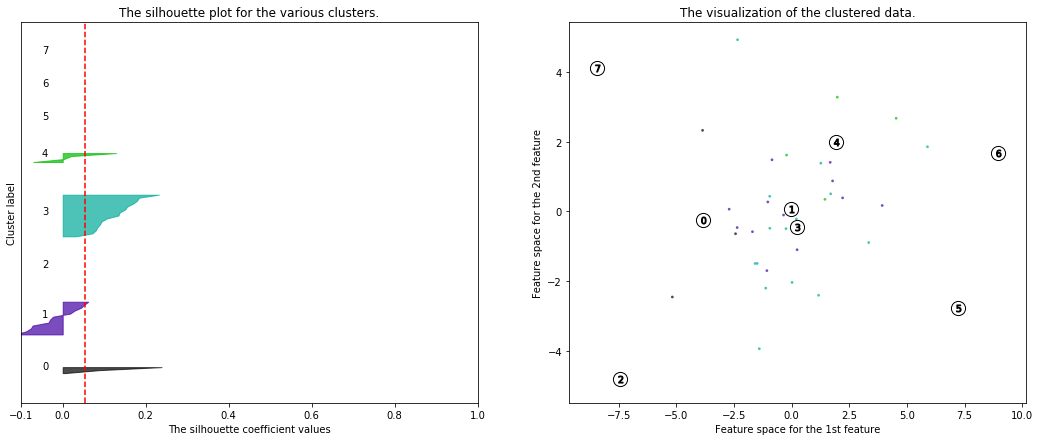

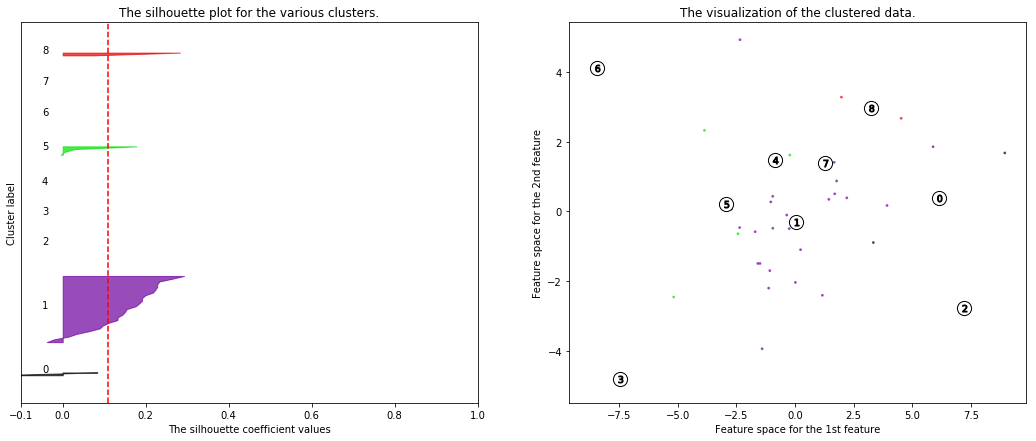

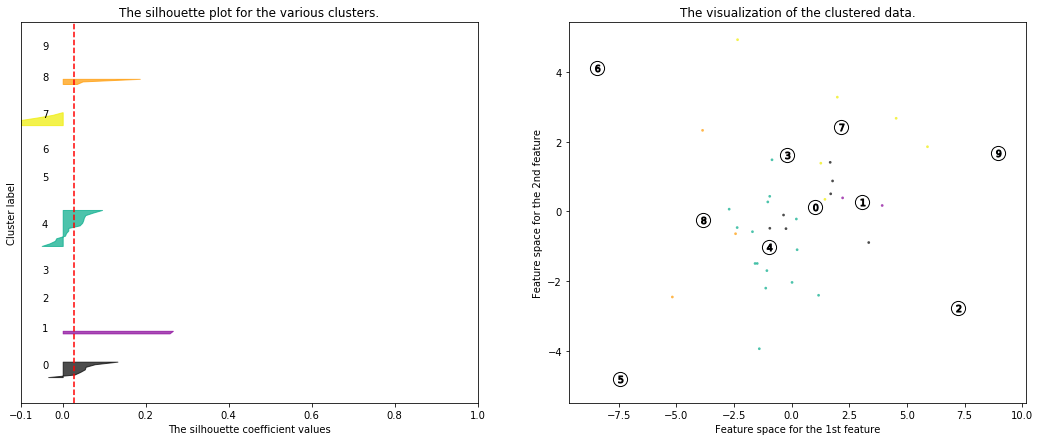

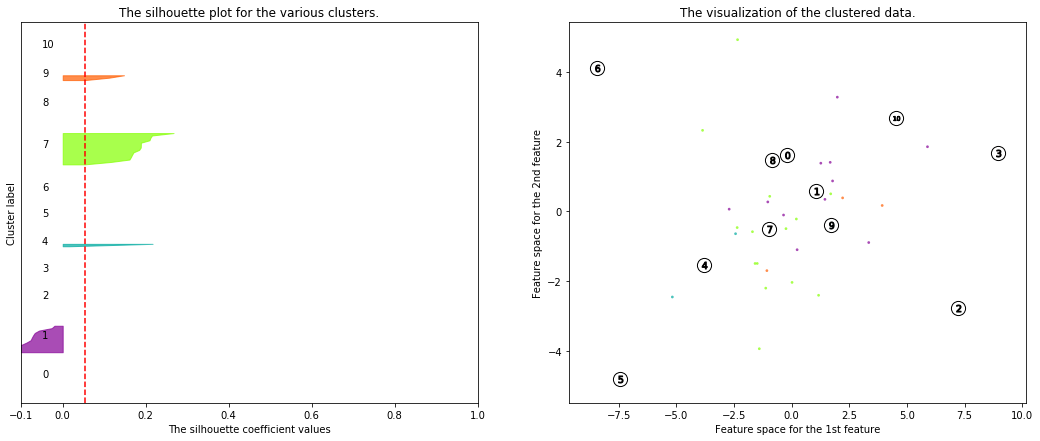

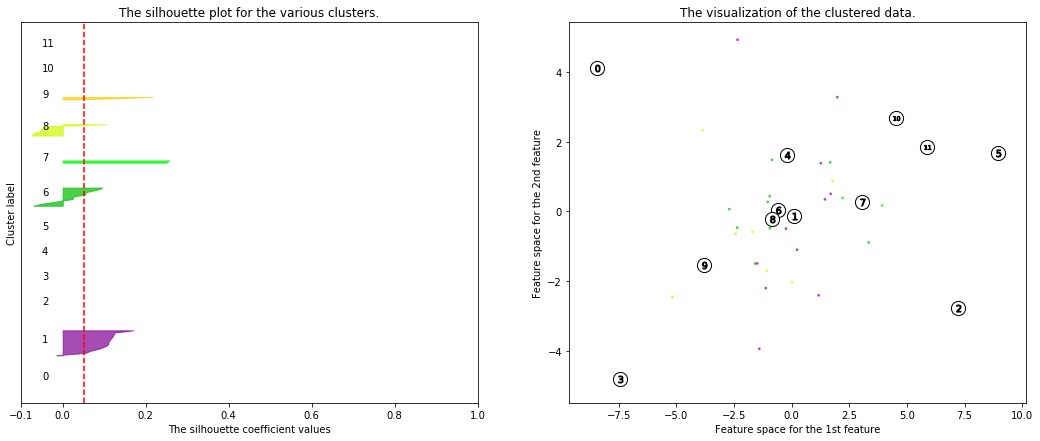

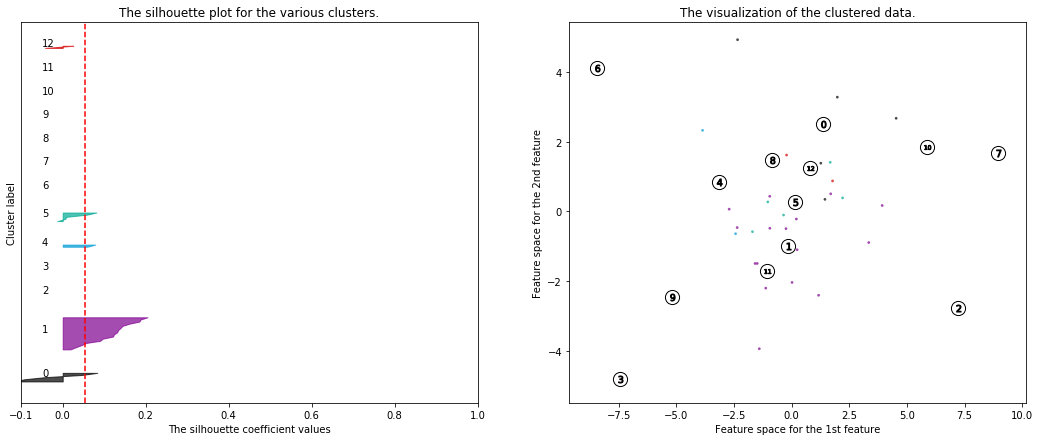

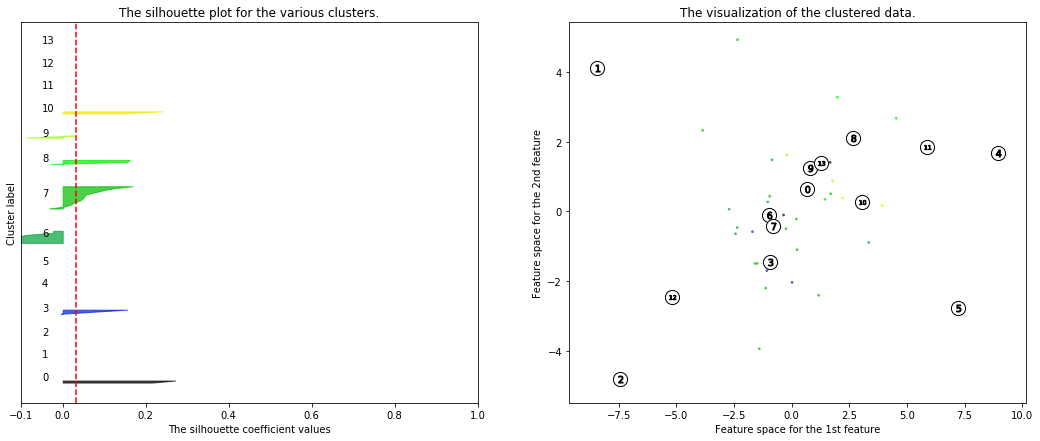

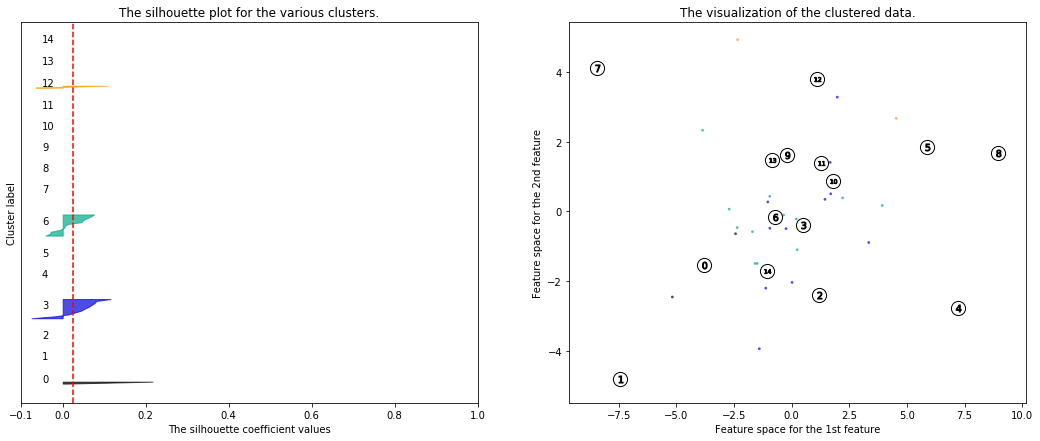

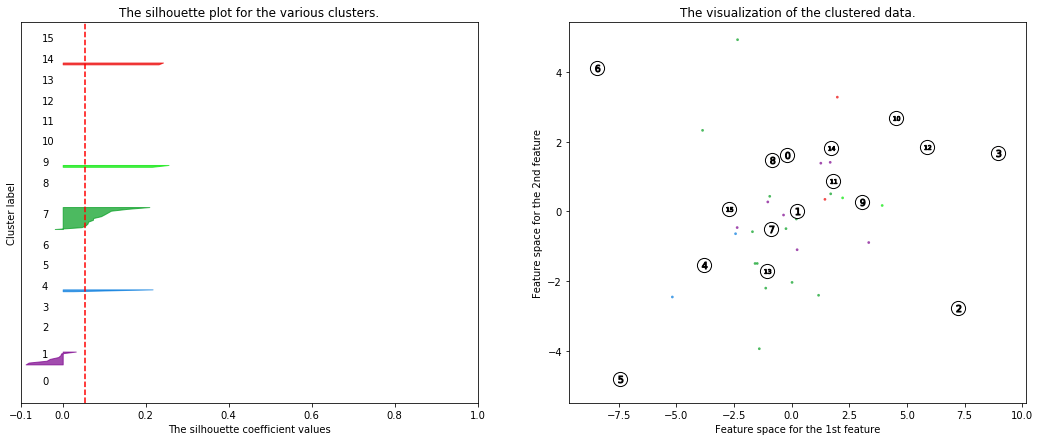

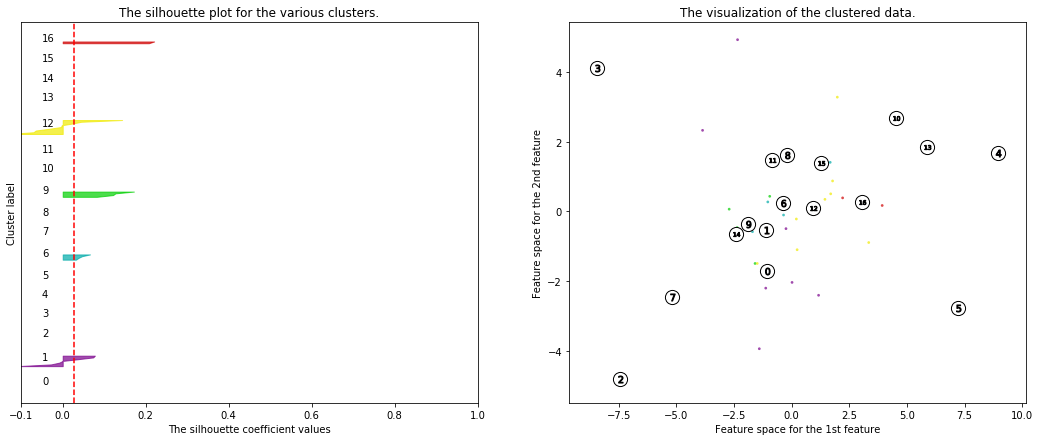

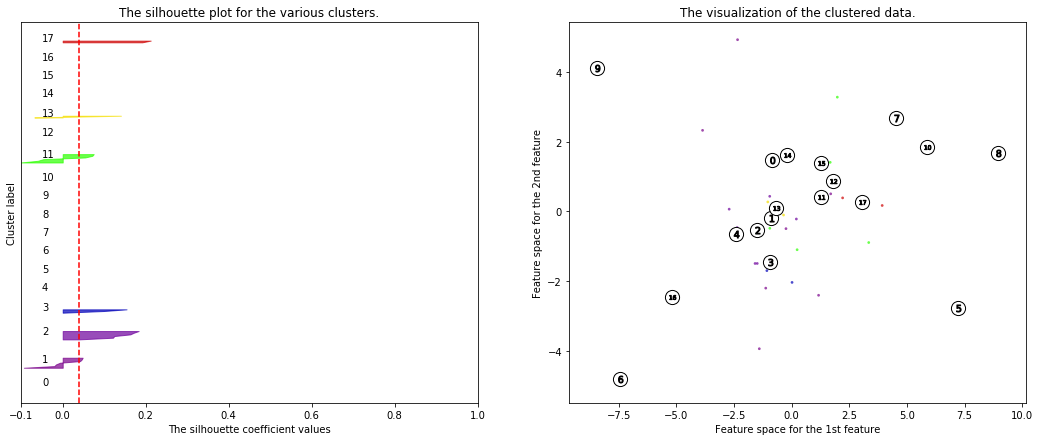

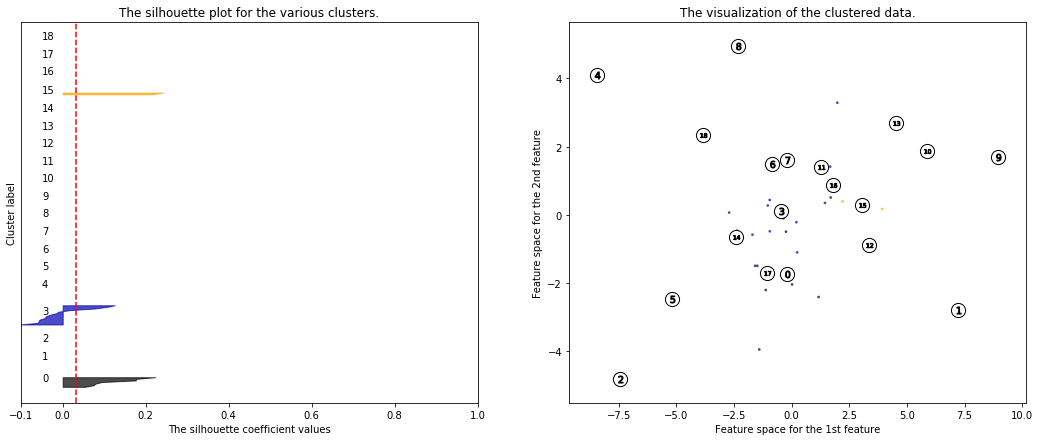

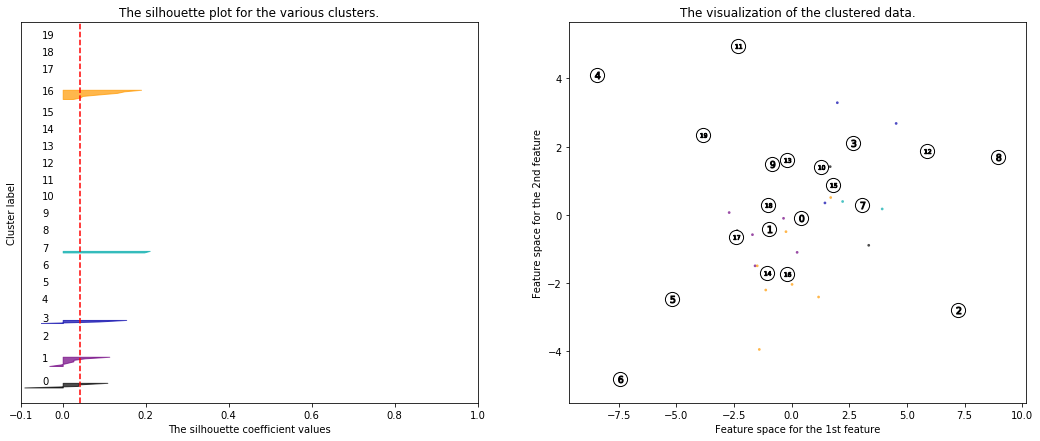

In [1168]:
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
range_n_clusters = [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_embedded) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=0, algorithm="full")
    cluster_labels = clusterer.fit_predict(X_embedded)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_embedded, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_embedded, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X_embedded[:, 0], X_embedded[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")


plt.show()

#### run *k*-means to cluster the neighborhood into 5 clusters.

In [1159]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=10, algorithm="full").fit(X_embedded)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 1, 2, 3, 2, 2, 2,
       0, 0, 0, 4, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2], dtype=int32)

In [1160]:
neighborhoods_venues_sorted.set_index('Neighborhood').reset_index().rename(columns={'Neighborhood': 'Neighbourhood'}).head()

Neighbourhood  Cluster Labels  \
0                                        Berczy Park               1   
1       Brockton, Parkdale Village, Exhibition Place               1   
2  Business Reply Mail Processing Centre 969 Eastern               1   
3                                 Central Bay Street               1   
4                                           Christie               1   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0           Coffee Shop          Cocktail Bar        Farmers Market   
1        Breakfast Spot                  Café           Coffee Shop   
2        Farmers Market         Auto Workshop                  Park   
3           Coffee Shop                  Café    Italian Restaurant   
4         Grocery Store                  Café                  Park   

  4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0              Beer Bar                Bakery            Steakhouse   
1           Yoga Studio                   Bar         Burrito Place   
2           Pizza Place            Restaurant         Burrito Place   
3        Ice Cream Shop        Sandwich Place          Burger Joint   
4    Italian Restaurant            Baby Store                 Diner   

       7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0                Cheese Shop    Seafood Restaurant                  Café   
1       Caribbean Restaurant            Restaurant          Climbing Gym   
2                    Brewery            Skate Park            Smoke Shop   
3  Middle Eastern Restaurant                   Spa                   Bar   
4         Athletics & Sports            Restaurant             Nightclub   

  10th Most Common Venue  
0                   Park  
1                    Gym  
2     Light Rail Station  
3                 Bakery  
4            Coffee Shop

In [1161]:
# add clustering labels
try:
    neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
except:
    pass

neighborhoods_venues_sorted['Cluster Labels'] = kmeans.labels_

toronto_merged = df_tor

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')

toronto_merged.head() # check the last columns!

Postcode           Borough              Neighbourhood   Latitude  \
2       M5A  Downtown Toronto  Harbourfront, Regent Park  43.654260   
9       M5B  Downtown Toronto   Garden District, Ryerson  43.657162   
15      M5C  Downtown Toronto             St. James Town  43.651494   
19      M4E      East Toronto                The Beaches  43.676357   
20      M5E  Downtown Toronto                Berczy Park  43.644771   

    Longitude  Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
2  -79.360636               0           Coffee Shop                  Café   
9  -79.378937               2           Coffee Shop        Clothing Store   
15 -79.375418               0           Coffee Shop                 Hotel   
19 -79.293031               0                   Pub     Health Food Store   
20 -79.373306               2           Coffee Shop          Cocktail Bar   

   3rd Most Common Venue 4th Most Common Venue      5th Most Common Venue  \
2                   Park                Bakery             Breakfast Spot   
9         Cosmetics Shop                  Café  Middle Eastern Restaurant   
15    Italian Restaurant                  Café                 Restaurant   
19  Other Great Outdoors                 Trail                Wings Joint   
20        Farmers Market              Beer Bar                     Bakery   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
2     Mexican Restaurant                   Pub            Shoe Store   
9       Ramen Restaurant            Restaurant  Fast Food Restaurant   
15          Cocktail Bar              Beer Bar        Cosmetics Shop   
19              Dive Bar               Dog Run      Doner Restaurant   
20            Steakhouse           Cheese Shop    Seafood Restaurant   

   9th Most Common Venue 10th Most Common Venue  
2                Brewery             Restaurant  
9                  Diner            Pizza Place  
15        Clothing Store         Breakfast Spot  
19            Donut Shop    Dumpling Restaurant  
20                  Café                   Park

#### Visualize resulting clustering

In [1162]:
import matplotlib.colors as colors


# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Clustering 1

In [1163]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

Borough  Cluster Labels 1st Most Common Venue  \
2    Downtown Toronto               0           Coffee Shop   
15   Downtown Toronto               0           Coffee Shop   
19       East Toronto               0                   Pub   
30   Downtown Toronto               0           Coffee Shop   
31       West Toronto               0                Bakery   
36   Downtown Toronto               0           Coffee Shop   
41       East Toronto               0      Greek Restaurant   
42   Downtown Toronto               0           Coffee Shop   
47       East Toronto               0             Pet Store   
54       East Toronto               0                  Café   
67    Central Toronto               0                   Gym   
68    Central Toronto               0                  Park   
69       West Toronto               0    Mexican Restaurant   
74    Central Toronto               0        Sandwich Place   
79    Central Toronto               0           Pizza Place   
80   Downtown Toronto               0                  Café   
87   Downtown Toronto               0       Airport Service   
91   Downtown Toronto               0                  Park   
97   Downtown Toronto               0           Coffee Shop   
99   Downtown Toronto               0           Coffee Shop   
100      East Toronto               0        Farmers Market   

    2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
2                    Café                  Park                Bakery   
15                  Hotel    Italian Restaurant                  Café   
19      Health Food Store  Other Great Outdoors                 Trail   
30                   Café       Thai Restaurant            Steakhouse   
31               Pharmacy           Supermarket                  Park   
36                  Hotel              Aquarium    Italian Restaurant   
41            Coffee Shop        Ice Cream Shop    Italian Restaurant   
42                   Café                 Hotel            Restaurant   
47                    Pub          Burger Joint         Burrito Place   
54            Coffee Shop    Italian Restaurant                Bakery   
67                  Hotel  Gym / Fitness Center        Clothing Store   
68                  Trail         Jewelry Store      Sushi Restaurant   
69                   Café                   Bar         Grocery Store   
74                   Café           Coffee Shop           Pizza Place   
79           Dessert Shop        Sandwich Place    Italian Restaurant   
80                    Bar            Restaurant   Japanese Restaurant   
87       Airport Terminal        Airport Lounge       Harbor / Marina   
91             Playground                 Trail              Building   
97                   Café            Restaurant                 Hotel   
99    Japanese Restaurant      Sushi Restaurant            Restaurant   
100         Auto Workshop                  Park           Pizza Place   

      5th Most Common Venue 6th Most Common Venue      7th Most Common Venue  \
2            Breakfast Spot    Mexican Restaurant                        Pub   
15               Restaurant          Cocktail Bar                   Beer Bar   
19              Wings Joint              Dive Bar                    Dog Run   
30                      Bar        Breakfast Spot                        Gym   
31                     Café               Brewery       Gym / Fitness Center   
36                     Café        Scenic Lookout                     Bakery   
41   Furniture / Home Store             Bookstore                    Brewery   
42       Italian Restaurant                Bakery              Deli / Bodega   
47     Fast Food Restaurant     Fish & Chips Shop             Sandwich Place   
54                Gastropub   American Restaurant                Cheese Shop   
67           Sandwich Place        Breakfast Spot          Food & Drink Shop   
68              Wings Joint              Dive Bar           

#### Clustering 2

In [1164]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

Borough  Cluster Labels 1st Most Common Venue  \
61  Central Toronto               1    Photography Studio   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
61                  Park              Bus Line           Swim School   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
61        Discount Store    Falafel Restaurant           Event Space   

   8th Most Common Venue 9th Most Common Venue       10th Most Common Venue  
61  Ethiopian Restaurant     Electronics Store  Eastern European Restaurant

#### Clustering 3

In [1165]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

Borough  Cluster Labels 1st Most Common Venue  \
9   Downtown Toronto               2           Coffee Shop   
20  Downtown Toronto               2           Coffee Shop   
24  Downtown Toronto               2           Coffee Shop   
25  Downtown Toronto               2         Grocery Store   
37      West Toronto               2                   Bar   
43      West Toronto               2        Breakfast Spot   
48  Downtown Toronto               2           Coffee Shop   
73   Central Toronto               2   Sporting Goods Shop   
75      West Toronto               2        Breakfast Spot   
81      West Toronto               2           Coffee Shop   
84  Downtown Toronto               2                  Café   
86   Central Toronto               2           Coffee Shop   
92  Downtown Toronto               2           Coffee Shop   
96  Downtown Toronto               2           Coffee Shop   

            2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
9                  Clothing Store        Cosmetics Shop                  Café   
20                   Cocktail Bar        Farmers Market              Beer Bar   
24                           Café    Italian Restaurant        Ice Cream Shop   
25                           Café                  Park    Italian Restaurant   
37                    Coffee Shop      Asian Restaurant                  Café   
43                           Café           Coffee Shop           Yoga Studio   
48                           Café                 Hotel            Restaurant   
73                    Coffee Shop        Clothing Store           Yoga Studio   
75                      Gift Shop                  Bank                   Bar   
81                    Pizza Place                  Café      Sushi Restaurant   
84  Vegetarian / Vegan Restaurant    Chinese Restaurant                   Bar   
86                            Pub    Light Rail Station   American Restaurant   
92                     Restaurant                  Café    Seafood Restaurant   
96                     Restaurant           Flower Shop                  Café   

        5th Most Common Venue 6th Most Common Venue  \
9   Middle Eastern Restaurant      Ramen Restaurant   
20                     Bakery            Steakhouse   
24             Sandwich Place          Burger Joint   
25                 Baby Store                 Diner   
37    New American Restaurant                Bakery   
43                        Bar         Burrito Place   
48        American Restaurant                Bakery   
73         Chinese Restaurant                   Spa   
75         Italian Restaurant         Movie Theater   
81         Italian Restaurant          Gourmet Shop   
84      Vietnamese Restaurant                Bakery   
86                Supermarket            Restaurant   
92               Cocktail Bar                 Hotel   
96         Italian Restaurant                Bakery   

        7th Most Common Venue 8th Most Common Venue  \
9                  Restaurant  Fast Food Restaurant   
20                Cheese Shop    Seafood Restaurant   
24  Middle Eastern Restaurant                   Spa   
25         Athletics & Sports            Restaurant   
37                Men's Store          Cocktail Bar   
43       Caribbean Restaurant            Restaurant   
48                  Gastropub    Seafood Restaurant   
73               Burger Joint         Metro Station   
75                 Restaurant          Dessert Shop   
81  Latin American Restaurant                   Bar   
84         Mexican Restaurant           Coffee Shop   
86           Sushi Restaurant   Fried Chicken Joint   
92                   Beer Bar  Fast Food Restaurant   
96                        Pub           Pizza Place   

          9th Most Common Venue 10th Most Common Venue  
9                         Diner            Pizza Place  
20                         Café                   Park  
24                          Bar            

#### Clustering 4

In [1166]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

Borough  Cluster Labels 1st Most Common Venue  \
83  Central Toronto               3            Playground   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
83                 Trail           Summer Camp           Wings Joint   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
83                 Diner    Falafel Restaurant           Event Space   

   8th Most Common Venue 9th Most Common Venue       10th Most Common Venue  
83  Ethiopian Restaurant     Electronics Store  Eastern European Restaurant

#### Clustering 5

In [1167]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

Borough  Cluster Labels 1st Most Common Venue  \
62  Central Toronto               4                Garden   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
62          Home Service           Wings Joint        Farmers Market   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
62    Falafel Restaurant           Event Space  Ethiopian Restaurant   

   8th Most Common Venue        9th Most Common Venue 10th Most Common Venue  
62     Electronics Store  Eastern European Restaurant    Dumpling Restaurant

## Conclusion
### In my attempts to create a good clusterings of toronto's neighborhood using kmeans, I found the best k as 4. I used various feature engineering such as one hot encoding, dimensional reduction, etc. And found the prefered k using silhouette analysis.
### By oberserving the clustering, One can see that the clustering make sense. For example, cluster 1 is geologically on the east and cluster 3 is geologically on the west, most common venue for cluster 3 are coffee shop and cafe, etc.
